## Export Images for Attention Walkthrough

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import transformer_lens
import torch.nn as nn
import einops
from jaxtyping import Float, Int
import torch as t
from torch import Tensor
from dataclasses import dataclass

In [4]:
sys.path.append('/home/stephen/deepseek/ARENA_3.0-main/chapter1_transformer_interp/exercises')
import part1_transformer_from_scratch.tests as tests

In [5]:
device='cuda'
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


### Start with 10 tokens, cut down as needed for viz to work

In [6]:
# reference_text = "The American flag is red, white, and"
reference_text = "The American flag is red, white, and blue"

In [7]:
tokens = model.to_tokens(reference_text).to(device)
logits, cache = model.run_with_cache(tokens)
logits.shape

torch.Size([1, 11, 50257])

In [8]:
def load_gpt2_test(cls, gpt2_layer, input):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    layer.load_state_dict(gpt2_layer.state_dict(), strict=False)
    print("Input shape:", input.shape)
    output = layer(input)
    if isinstance(output, tuple):
        output = output[0]
    print("Output shape:", output.shape)
    try:
        reference_output = gpt2_layer(input)
    except:
        reference_output = gpt2_layer(input, input, input)
    print("Reference output shape:", reference_output.shape, "\n")
    comparison = t.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
    print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")
    assert 1 - (comparison.sum() / comparison.numel()) < 1e-5, "More than 0.01% of the values are incorrect"

In [9]:
@dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12


cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)


In [10]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def forward(self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]) -> Float[Tensor, "batch posn d_model"]:
        # Calculate query, key and value vectors
        q = (
            einops.einsum(
                normalized_resid_pre, self.W_Q, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )
            + self.b_Q
        )
        k = (
            einops.einsum(
                normalized_resid_pre, self.W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )
            + self.b_K
        )
        v = (
            einops.einsum(
                normalized_resid_pre, self.W_V, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )
            + self.b_V
        )

        # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
        attn_scores = einops.einsum(
            q, k, "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K"
        )
        attn_scores_masked = self.apply_causal_mask(attn_scores / self.cfg.d_head**0.5)
        attn_pattern = attn_scores_masked.softmax(-1)

        # Take weighted sum of value vectors, according to attention probabilities
        z = einops.einsum(
            v, attn_pattern, "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head"
        )

        # Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
        attn_out = (
            einops.einsum(z, self.W_O, "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model")
            + self.b_O
        )

        return attn_out

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores


# tests.test_causal_mask(Attention.apply_causal_mask)
# rand_float_test(Attention, [2, 4, 768])
load_gpt2_test(Attention, model.blocks[0].attn, cache["normalized", 0, "ln1"])

Input shape: torch.Size([1, 11, 768])
Output shape: torch.Size([1, 11, 768])
Reference output shape: torch.Size([1, 11, 768]) 

100.00% of the values are correct



In [11]:
cfg = Config(debug=True)
layer = Attention(cfg).to(device)
layer.load_state_dict(model.blocks[0].attn.state_dict(), strict=False);

output = layer(cache["normalized", 0, "ln1"])
reference_output = model.blocks[0].attn(cache["normalized", 0, "ln1"], cache["normalized", 0, "ln1"], cache["normalized", 0, "ln1"])

comparison = t.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")
assert 1 - (comparison.sum() / comparison.numel()) < 1e-5, "More than 0.01% of the values are incorrect"

100.00% of the values are correct



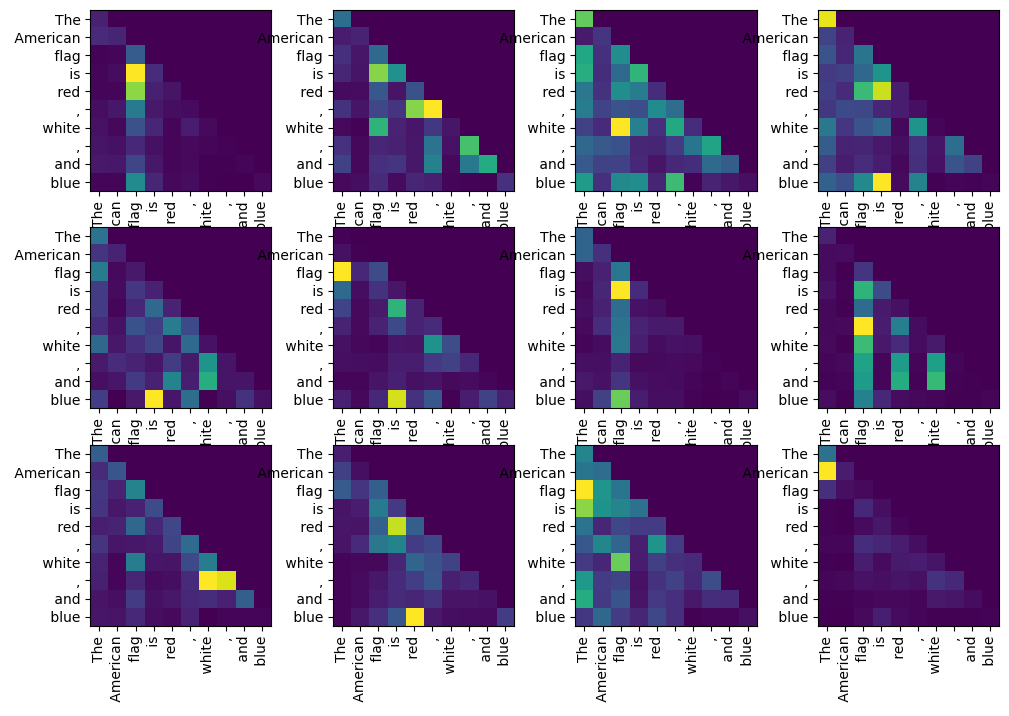

In [29]:
token_string_list=model.to_str_tokens(tokens)
attn_pattern=cache['blocks.10.attn.hook_pattern']
fig=figure(0,(12,8))
for i in range(12):
    ax=fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy()[1:,1:])
    ax.set_xticks(np.arange(len(token_string_list)-1))
    ax.set_xticklabels(token_string_list[1:])
    plt.xticks(rotation=90)
    ax.set_yticks(np.arange(len(token_string_list)-1))
    ax.set_yticklabels(token_string_list[1:])
plt.show()

In [12]:
token_string_list

['<|endoftext|>',
 'The',
 ' American',
 ' flag',
 ' is',
 ' red',
 ',',
 ' white',
 ',',
 ' and',
 ' blue']

### Data & Code Moving
```
rsync -auv stephen@dev-3:/home/stephen/deepseek /Users/stephen/Dropbox/welch_labs/deepseek/hackin/linux_workdir --exclude DeepSeek-V3
```

- Now I want to use a specific head and layer I think -> how I do that?

In [13]:
layer_id=10

In [14]:
cfg = Config(debug=True)
layer = Attention(cfg).to(device)
layer.load_state_dict(model.blocks[layer_id].attn.state_dict(), strict=False);

In [15]:
W_Q=layer.W_Q 
W_K=layer.W_K
W_V=layer.W_V
W_O=layer.W_O 
b_Q=layer.b_Q
b_K=layer.b_K 
b_V=layer.b_V 
b_O=layer.b_O

In [16]:
W_Q.shape, W_K.shape, W_V.shape, W_O.shape

(torch.Size([12, 768, 64]),
 torch.Size([12, 768, 64]),
 torch.Size([12, 768, 64]),
 torch.Size([12, 64, 768]))

In [17]:
normalized_resid_pre=cache["normalized", layer_id, "ln1"] #This i think?

In [18]:
normalized_resid_pre.shape

torch.Size([1, 11, 768])

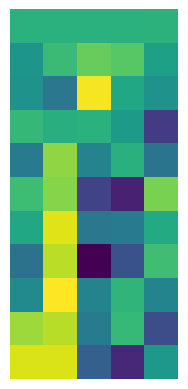

In [19]:
x_numpy=normalized_resid_pre.detach().cpu().numpy()[0]
plt.imshow(x_numpy[:,:5])
plt.axis('off')
plt.savefig('flowchart_graphics_2/input_1_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

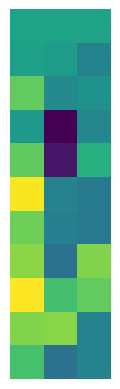

In [20]:
plt.imshow(x_numpy[:,-3:])
plt.axis('off')
plt.savefig('flowchart_graphics_2/input_2_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [21]:
#There's more efficient ways to do this -> but this is one matrix multiply per head 
qs=[]
for head_num in range(cfg.n_heads):
    qs.append(normalized_resid_pre[0] @ W_Q[head_num] +b_Q[head_num]) 
q=t.stack(qs, dim=0).unsqueeze(0).permute(0, 2, 1, 3) #Stack results together, add batch dimension, switch token and head dims.

In [22]:
q.shape

torch.Size([1, 11, 12, 64])

In [23]:
head_id=7

In [24]:
q_to_viz=q[0,:,head_id,:].detach().cpu().numpy()

In [25]:
W_Q_to_viz=W_Q[head_id].detach().cpu().numpy()

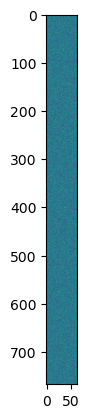

In [26]:
plt.imshow(W_Q_to_viz)
plt.show()

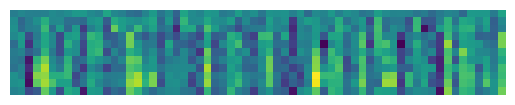

In [27]:
plt.imshow(q_to_viz)
plt.axis('off')
plt.savefig('flowchart_graphics_2/q_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [28]:
k = (
    einops.einsum(
        normalized_resid_pre, W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
    )
    + b_K
)

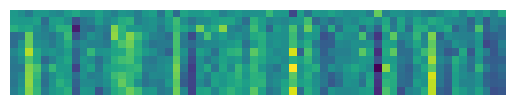

In [29]:
k_to_viz=k[0,:,head_id,:].detach().cpu().numpy()
plt.imshow(k_to_viz)
plt.axis('off')
plt.savefig('flowchart_graphics_2/k_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [30]:
v = (
    einops.einsum(
        normalized_resid_pre, W_V, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
    )
    + b_V
)

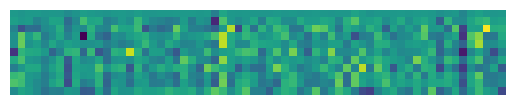

In [31]:
v_to_viz=v[0,:,head_id,:].detach().cpu().numpy()
plt.imshow(v_to_viz)
plt.axis('off')
plt.savefig('flowchart_graphics_2/v_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [32]:
# Calculate attention scores, then scale and mask, and apply softmax to get probabilities
attn_scores = einops.einsum(
    q, k, "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K"
)

attn_scores_masked = layer.apply_causal_mask(attn_scores / layer.cfg.d_head**0.5)
attn_pattern = attn_scores_masked.softmax(-1)

In [33]:
attn_pattern.shape

torch.Size([1, 12, 11, 11])

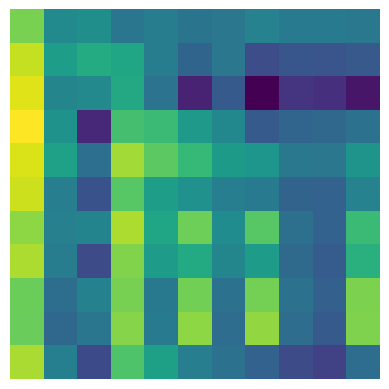

In [34]:
attn_scores_to_viz=attn_scores[0,head_id,:,:].detach().cpu().numpy()
plt.imshow(attn_scores_to_viz)
plt.axis('off')
plt.savefig('flowchart_graphics_2/attention_scores.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

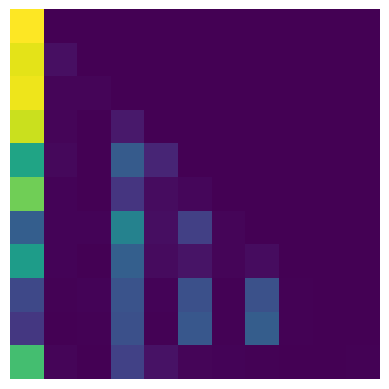

In [35]:
attn_pattern_to_viz=attn_pattern[0,head_id,:,:].detach().cpu().numpy()
plt.imshow(attn_pattern_to_viz)
plt.axis('off')
plt.savefig('flowchart_graphics_2/attention_pattern.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [36]:
zs=[]
for head_num in range(cfg.n_heads):
    zs.append(attn_pattern[0, head_num, :, :] @ v[0, :, head_num, :])

# z=t.stack(zs, dim=0).unsqueeze(0).permute(0, 2, 1, 3) #

# Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
# attn_out = (
#     einops.einsum(z, W_O, "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model")
#     + b_O
# )

# attn_out=((W_O.reshape(-1, 768).T @ z[0].reshape(10, -1).T).T+b_O).unsqueeze(0)  #Defintely change this if I transpose things - clunky as hell

In [37]:
W_O.shape

torch.Size([12, 64, 768])

In [38]:
zs[0].shape

torch.Size([11, 64])

In [39]:
z=t.concatenate(zs, dim=1) #.permute(1,0,2)

In [40]:
z.shape

torch.Size([11, 768])

In [41]:
12*64

768

In [42]:
W_Or=W_O.reshape(-1, 768)

In [43]:
W_Or.shape

torch.Size([768, 768])

In [44]:
attn_out = z @ W_Or + b_O

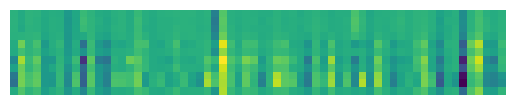

In [45]:
z_to_viz=zs[head_id].detach().cpu().numpy()
plt.imshow(z_to_viz)
plt.axis('off')
plt.savefig('flowchart_graphics_2/z_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [46]:
z_to_viz=z.detach().cpu().numpy()
plt.imshow(z_to_viz)
plt.axis('off')
plt.savefig('flowchart_graphics_2/z_all_heads_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

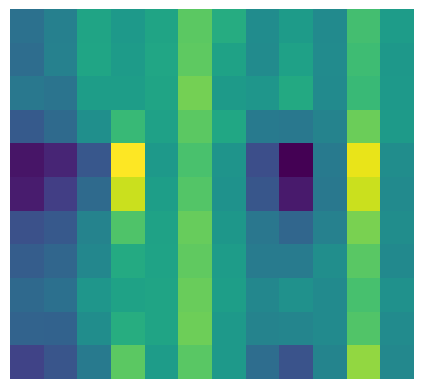

In [47]:
z_to_viz=z.detach().cpu().numpy()
plt.imshow(z_to_viz[:,:12])
plt.axis('off')
plt.savefig('flowchart_graphics_2/z_all_heads_start_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

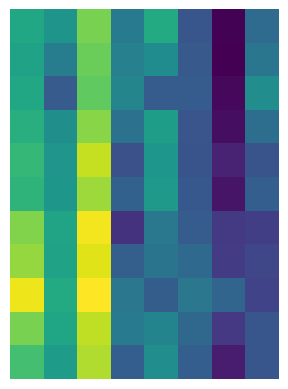

In [48]:
z_to_viz=z.detach().cpu().numpy()
plt.imshow(z_to_viz[:, -8:])
plt.axis('off')
plt.savefig('flowchart_graphics_2/z_all_heads_end_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [49]:
attn_out.shape

torch.Size([11, 768])

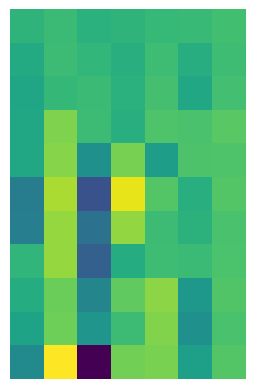

In [50]:
attn_out_to_viz=attn_out.detach().cpu().numpy()
plt.imshow(attn_out_to_viz[:,:7])
plt.axis('off')
plt.savefig('flowchart_graphics_2/attn_out_start_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

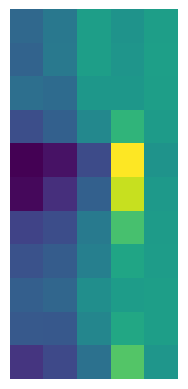

In [51]:
attn_out_to_viz=attn_out.detach().cpu().numpy()
plt.imshow(z_to_viz[:,:5])
plt.axis('off')
plt.savefig('flowchart_graphics_2/attn_out_end_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [52]:
# model.blocks[9]

In [1]:
reference_output = model.blocks[layer_id].attn(cache["normalized", layer_id, "ln1"], cache["normalized", layer_id, "ln1"], cache["normalized", layer_id, "ln1"])

comparison = t.isclose(attn_out, reference_output, atol=1e-4, rtol=1e-3)
print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")
assert 1 - (comparison.sum() / comparison.numel()) < 1e-5, "More than 0.01% of the values are incorrect"

NameError: name 'model' is not defined

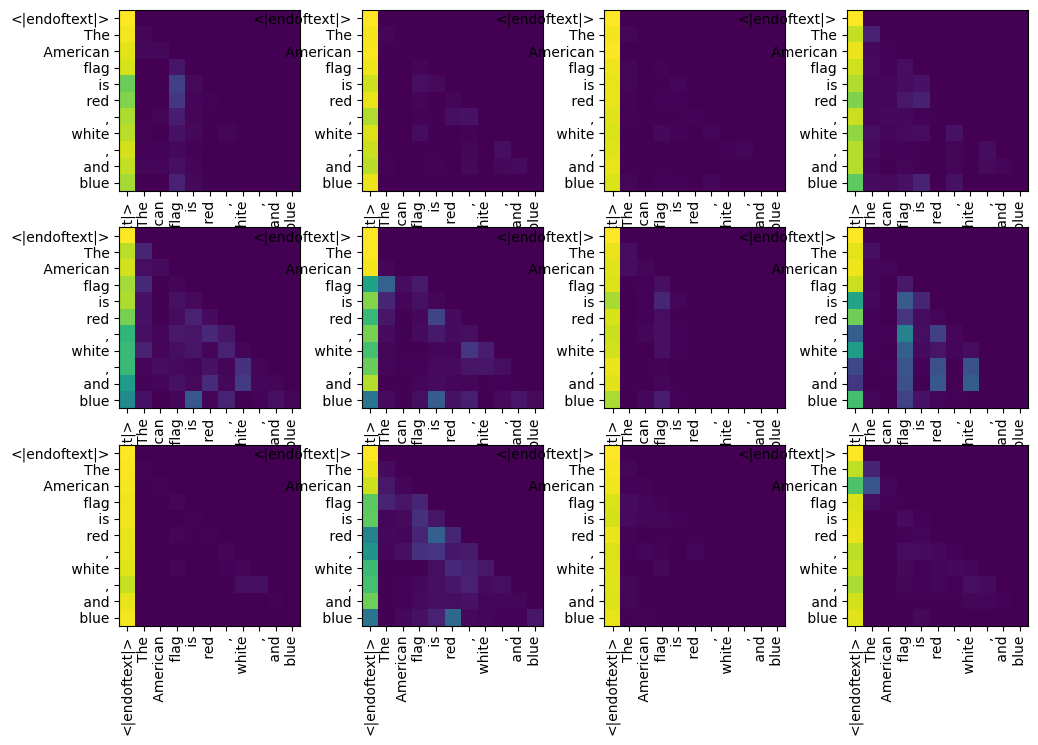

In [54]:
# attn_pattern=attn_scores #cache['blocks.10.attn.hook_pattern']
fig=figure(0,(12,8))
for i in range(12):
    ax=fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
    ax.set_xticks(np.arange(len(token_string_list)))
    ax.set_xticklabels(token_string_list)
    plt.xticks(rotation=90)
    ax.set_yticks(np.arange(len(token_string_list)))
    ax.set_yticklabels(token_string_list)
plt.show()

----

In [55]:
# token_string_list=model.to_str_tokens(tokens)
# attn_pattern=cache['blocks.10.attn.hook_pattern']
# fig=figure(0,(12,8))
# for i in range(12):
#     ax=fig.add_subplot(3,4,i+1)
#     plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
#     ax.set_xticks(np.arange(len(token_string_list)))
#     ax.set_xticklabels(token_string_list)
#     plt.xticks(rotation=90)
#     ax.set_yticks(np.arange(len(token_string_list)))
#     ax.set_yticklabels(token_string_list)
# plt.show()